In [1]:
! pip install pandas numpy statsmodels matplotlib seaborn pyspark prophet


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
#Data Processing
import pandas as pd
import numpy as np

#Prophet model for time series forecast
from prophet import Prophet

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Multi-processing
from multiprocessing import Pool, cpu_count

#Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

#Process bar
from tqdm import tqdm

#Tracking time
from time import time

from statsmodels.distributions.empirical_distribution import ECDF

/Users/hanvu/src/Rossman sales analytics/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


<h2>I. DATA LOADING<h2>

We will load the 2 datasets: train and store

In [22]:
#Importing the training dataset
df_train = pd.read_csv('train.csv')
df_train

/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/1452678559.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('train.csv')


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-17,4852,519,1,1,0,0,303445
1,2,5,2015-07-17,4518,495,1,1,0,1,959585
2,3,5,2015-07-17,6679,673,1,1,0,1,739744
3,4,5,2015-07-17,10514,1343,1,1,0,1,864001
4,5,5,2015-07-17,4355,513,1,1,0,1,981931
...,...,...,...,...,...,...,...,...,...,...
1001594,1111,2,2013-01-01,0,0,0,0,a,1,225066
1001595,1112,2,2013-01-01,0,0,0,0,a,1,775592
1001596,1113,2,2013-01-01,0,0,0,0,a,1,135205
1001597,1114,2,2013-01-01,0,0,0,0,a,1,954751


In [23]:
#Extract year, month, day, and week of year from date to help further analysis
# Convert Date column to datetime if not already
df_train['Date'] = pd.to_datetime(df_train['Date'])

# Extract date components
df_train['Year'] = df_train['Date'].dt.year
df_train['Month'] = df_train['Date'].dt.month
df_train['Day'] = df_train['Date'].dt.day
df_train['WeekOfYear'] = df_train['Date'].dt.isocalendar().week

# Verify the new columns
print(df_train[['Date', 'Year', 'Month', 'Day', 'WeekOfYear']].head())

        Date  Year  Month  Day  WeekOfYear
0 2015-07-17  2015      7   17          29
1 2015-07-17  2015      7   17          29
2 2015-07-17  2015      7   17          29
3 2015-07-17  2015      7   17          29
4 2015-07-17  2015      7   17          29


In [24]:
#Importing the dataset containing store's characteristics
df_store = pd.read_csv('store.csv')
df_store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


<h2>II. DATA UNDERSTANDING<h2>

In this section we will get some understanding about our data focusing on descriptive statistics and handling missing value

In [7]:
#Check the overall info of the dataset
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001599 entries, 0 to 1001598
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1001599 non-null  int64         
 1   DayOfWeek      1001599 non-null  int64         
 2   Date           1001599 non-null  datetime64[ns]
 3   Sales          1001599 non-null  int64         
 4   Customers      1001599 non-null  int64         
 5   Open           1001599 non-null  int64         
 6   Promo          1001599 non-null  int64         
 7   StateHoliday   1001599 non-null  object        
 8   SchoolHoliday  1001599 non-null  int64         
 9   Id             1001599 non-null  int64         
 10  Year           1001599 non-null  int32         
 11  Month          1001599 non-null  int32         
 12  Day            1001599 non-null  int32         
 13  WeekOfYear     1001599 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), i

In [8]:
#Check the missing values in the train dataset
df_train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Id               0
Year             0
Month            0
Day              0
WeekOfYear       0
dtype: int64

As we can see, the train dataset does not have any missing values. 
However, we observe that there are some days that have zero sales. We need to deal with this before conducting further analysis

In [9]:
df_train['Sales'].describe()

count    1.001599e+06
mean     5.770573e+03
std      3.852568e+03
min      0.000000e+00
25%      3.722000e+03
50%      5.741000e+03
75%      7.854000e+03
max      4.155100e+04
Name: Sales, dtype: float64

We will create a new feature: sales per customer to understand the relationship between number of sales and customers

In [25]:
df_train['Sales Per Customer'] = df_train['Sales']/df_train['Customers']
df_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,Year,Month,Day,WeekOfYear,Sales Per Customer
0,1,5,2015-07-17,4852,519,1,1,0,0,303445,2015,7,17,29,9.348748
1,2,5,2015-07-17,4518,495,1,1,0,1,959585,2015,7,17,29,9.127273
2,3,5,2015-07-17,6679,673,1,1,0,1,739744,2015,7,17,29,9.924220
3,4,5,2015-07-17,10514,1343,1,1,0,1,864001,2015,7,17,29,7.828742
4,5,5,2015-07-17,4355,513,1,1,0,1,981931,2015,7,17,29,8.489279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001594,1111,2,2013-01-01,0,0,0,0,a,1,225066,2013,1,1,1,NaN
1001595,1112,2,2013-01-01,0,0,0,0,a,1,775592,2013,1,1,1,NaN
1001596,1113,2,2013-01-01,0,0,0,0,a,1,135205,2013,1,1,1,NaN
1001597,1114,2,2013-01-01,0,0,0,0,a,1,954751,2013,1,1,1,NaN


We can check the distribution of Sales, Customers, and Sales Per Customer through EDCF

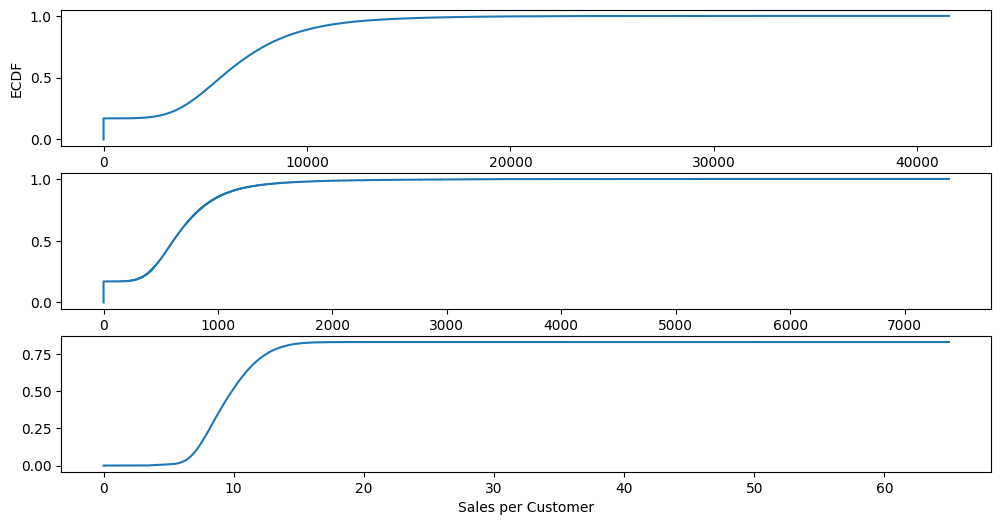

In [11]:
#sns.set_theme(style = "ticks")
plt.figure(figsize = (12, 6))

plt.subplot(311)
CDF = ECDF(df_train['Sales'])
plt.plot(CDF.x, CDF.y);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(df_train['Customers'])
plt.plot(cdf.x, cdf.y);
plt.xlabel('Customers');

# plot third ECDF  
plt.subplot(313)
cdf = ECDF(df_train['Sales Per Customer'])
plt.plot(cdf.x, cdf.y);
plt.xlabel('Sales per Customer');


As we can see, nearly 20% of Sales and Customers are zero. We need to check whether stores are open on the date that have zero sales and customers or not

In [26]:
#Check the number of closed date and have zero sales
df_train[(df_train['Sales'] == 0) & (df_train['Open']==0)].shape

(170627, 15)

In [27]:
#Check the number of open date but have zero sales
df_train[(df_train['Sales'] == 0) & (df_train['Open']!=0)].shape

(54, 15)

There are 170627 stores that are closed and have zero sales, so we will drop these rows to focus on predicting sales for the open ones.

In [28]:
df_train = df_train[(df_train["Open"] != 0) & (df_train['Sales'] != 0)]
df_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,Year,Month,Day,WeekOfYear,Sales Per Customer
0,1,5,2015-07-17,4852,519,1,1,0,0,303445,2015,7,17,29,9.348748
1,2,5,2015-07-17,4518,495,1,1,0,1,959585,2015,7,17,29,9.127273
2,3,5,2015-07-17,6679,673,1,1,0,1,739744,2015,7,17,29,9.924220
3,4,5,2015-07-17,10514,1343,1,1,0,1,864001,2015,7,17,29,7.828742
4,5,5,2015-07-17,4355,513,1,1,0,1,981931,2015,7,17,29,8.489279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001166,682,2,2013-01-01,3375,566,1,0,a,1,456248,2013,1,1,1,5.962898
1001217,733,2,2013-01-01,10765,2377,1,0,a,1,399778,2013,1,1,1,4.528818
1001253,769,2,2013-01-01,5035,1248,1,0,a,1,725271,2013,1,1,1,4.034455
1001432,948,2,2013-01-01,4491,1039,1,0,a,1,776356,2013,1,1,1,4.322425


Now we will take a look at store characteristics

In [29]:
#Check the info of the dataset
print(df_store.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None


In [30]:
#Check the missing value of store dataset
df_store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [23]:
#Check again the statistical info of Competition Distance variable
print(df_store['CompetitionDistance'].describe())

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64


Because Competition Distance's mean is higher than its median, the data is right skewed (or positively skewed)

Because there are only 3 null values in competition distance, so it's logical to impute NaN value by median

In [31]:
#Replace null value with the median value
val = df_store['CompetitionDistance'].median()
df_store['CompetitionDistance'].fillna(val, inplace=True)

/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/4210141361.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_store['CompetitionDistance'].fillna(val, inplace=True)


In [32]:
#Check again the number of null values of CompetitionDistance variable
df_store['CompetitionDistance'].isnull().sum()

np.int64(0)

Now we will move on to processing the missing value for Competition Open time and Promo2 time

In [34]:
_ = df_store[pd.isnull(df_store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape
#no promo time means no promo2 happened

(0, 10)

Because no promo time means no promo2 happened, we can replace all the NaN value in the Promo2 time by 0 (and the same with Competition Open Time)

In [33]:
#Replacing NaN with 0
df_store.replace(np.nan, 0, inplace=True)

In [34]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


All the null value is gone, now we will move onto EDA

<h2>III. EDA & VISUALIZATION<h2>

Merge the 2 datasets for more information

In [35]:
#Join 2 datasets together
train_store = pd.merge(df_train, df_store, how='left', on='Store')
train_store

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,...,Sales Per Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-17,4852,519,1,1,0,0,303445,...,9.348748,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-17,4518,495,1,1,0,1,959585,...,9.127273,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-17,6679,673,1,1,0,1,739744,...,9.924220,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-17,10514,1343,1,1,0,1,864001,...,7.828742,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-17,4355,513,1,1,0,1,981931,...,8.489279,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830913,682,2,2013-01-01,3375,566,1,0,a,1,456248,...,5.962898,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
830914,733,2,2013-01-01,10765,2377,1,0,a,1,399778,...,4.528818,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
830915,769,2,2013-01-01,5035,1248,1,0,a,1,725271,...,4.034455,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
830916,948,2,2013-01-01,4491,1039,1,0,a,1,776356,...,4.322425,b,b,1430.0,0.0,0.0,0,0.0,0.0,0


We will generate heatmap to see the correlation between Sales (target variable) and other predictive variables

In [36]:
corr_matrix = train_store.drop('Open', axis=1).corr(numeric_only = True)
corr_matrix

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,Id,Year,Month,Day,WeekOfYear,Sales Per Customer,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
Store,1.000000,0.000338,0.007795,0.034043,-0.000012,0.000269,-0.000561,0.000337,0.001390,-0.000108,0.001319,-0.048503,-0.027023,-0.032606,-0.008206,0.007768,0.010903,0.007800
DayOfWeek,0.000338,1.000000,-0.179012,-0.097433,-0.289864,-0.136660,0.000218,0.002208,-0.019875,0.008762,-0.014236,-0.094994,0.005478,-0.000839,-0.001310,-0.003231,-0.002709,-0.003228
Sales,0.007795,-0.179012,1.000000,0.824032,0.367238,0.036267,0.000839,0.037083,0.074202,-0.055358,0.074881,0.185822,-0.036795,-0.018045,0.005683,-0.127948,-0.058918,-0.127973
Customers,0.034043,-0.097433,0.824032,1.000000,0.182686,0.023948,0.000955,0.001496,0.054812,-0.035504,0.054841,-0.323843,-0.148657,-0.020731,0.002003,-0.202298,-0.130956,-0.202271
Promo,-0.000012,-0.289864,0.367238,0.182686,1.000000,0.023735,-0.000097,0.026222,-0.006109,-0.134198,0.006874,0.279252,-0.002371,0.000719,0.000995,-0.000325,-0.000806,-0.000326
SchoolHoliday,0.000269,-0.136660,0.036267,0.023948,0.023735,1.000000,0.001187,-0.065699,0.115312,0.018685,0.073286,0.011783,-0.005008,-0.000921,-0.000959,-0.003994,-0.003870,-0.003996
Id,-0.000561,0.000218,0.000839,0.000955,-0.000097,0.001187,1.000000,0.000134,-0.000737,0.001527,-0.001030,-0.000888,0.000226,0.000747,0.000583,-0.001337,-0.003029,-0.001337
Year,0.000337,0.002208,0.037083,0.001496,0.026222,-0.065699,0.000134,1.000000,-0.282737,-0.017224,-0.271163,0.069366,0.000739,-0.000580,-0.000167,-0.006466,-0.007842,-0.006467
Month,0.001390,-0.019875,0.074202,0.054812,-0.006109,0.115312,-0.000737,-0.282737,1.000000,-0.012523,0.961019,0.014266,0.003937,-0.001368,-0.000774,-0.026180,-0.032185,-0.026185
Day,-0.000108,0.008762,-0.055358,-0.035504,-0.134198,0.018685,0.001527,-0.017224,-0.012523,1.000000,0.036078,-0.031683,-0.000149,-0.000218,-0.000324,0.000950,0.000957,0.000950


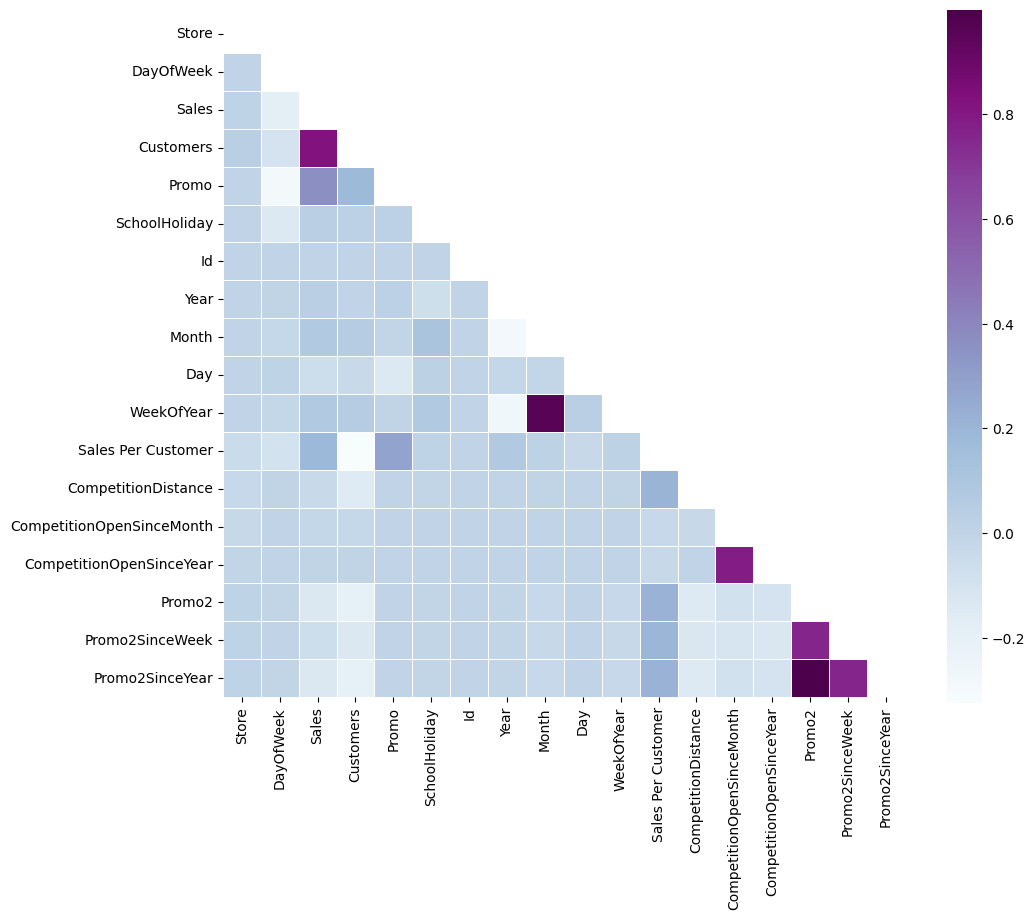

In [37]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype = bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

We can see that there is a high correlation between Sales and number of Customers.
Promo is also a variable that has positive impact on Sales
Promo2 even has negative impacts on Sales

We will start looking closely at each variable and its impact on Sales

<h3>1. Sales Distribution based on Store Type<h3>

In [38]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,449818.0,6927.625818,3279.315074,46.0,4696.00,6286.0,8408.0,41551.0
b,15322.0,10228.080929,5161.154996,1252.0,6337.25,9128.0,13186.5,38722.0
c,111192.0,6933.116933,2900.733774,133.0,4914.00,6407.0,8349.0,31448.0
d,254586.0,6818.943701,2557.107129,538.0,5046.00,6391.0,8121.0,38037.0


In [39]:
train_store.groupby('StoreType')['Customers'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,449818.0,796.218811,387.892355,8.0,547.0,721.0,950.00,7388.0
b,15322.0,2021.520493,911.743406,219.0,1254.0,1836.5,2748.75,5494.0
c,111192.0,816.243039,330.315449,18.0,583.0,757.0,982.00,3096.0
d,254586.0,606.587342,199.620764,64.0,464.0,577.0,717.00,2239.0


As we can see, Store Type B has the highest sales volumns, while the others demonstrate similar sales level. What about Sales per customer?

In [40]:
train_store.groupby('StoreType')['Sales Per Customer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,449818.0,8.83933,1.687958,3.635389,7.607717,8.624064,9.889971,29.877551
b,15322.0,5.13125,1.253250,2.749075,4.038114,4.986191,6.106540,9.203528
c,111192.0,8.61868,1.692839,3.382542,7.410974,8.416382,9.633055,64.957854
d,254586.0,11.26857,1.987948,4.881279,9.866667,11.186589,12.549578,57.614983


Interestingly, although store type b has the highest volumns of sales, it is the one that has lowest sales per customer. It demonstrates that store type b sells goods in the low price range, while the opposite is true for store type d.

We will have a graph to see the patterns of sales, customers, and sales per customer

/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/1829374141.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


<Figure size 2000x1500 with 0 Axes>

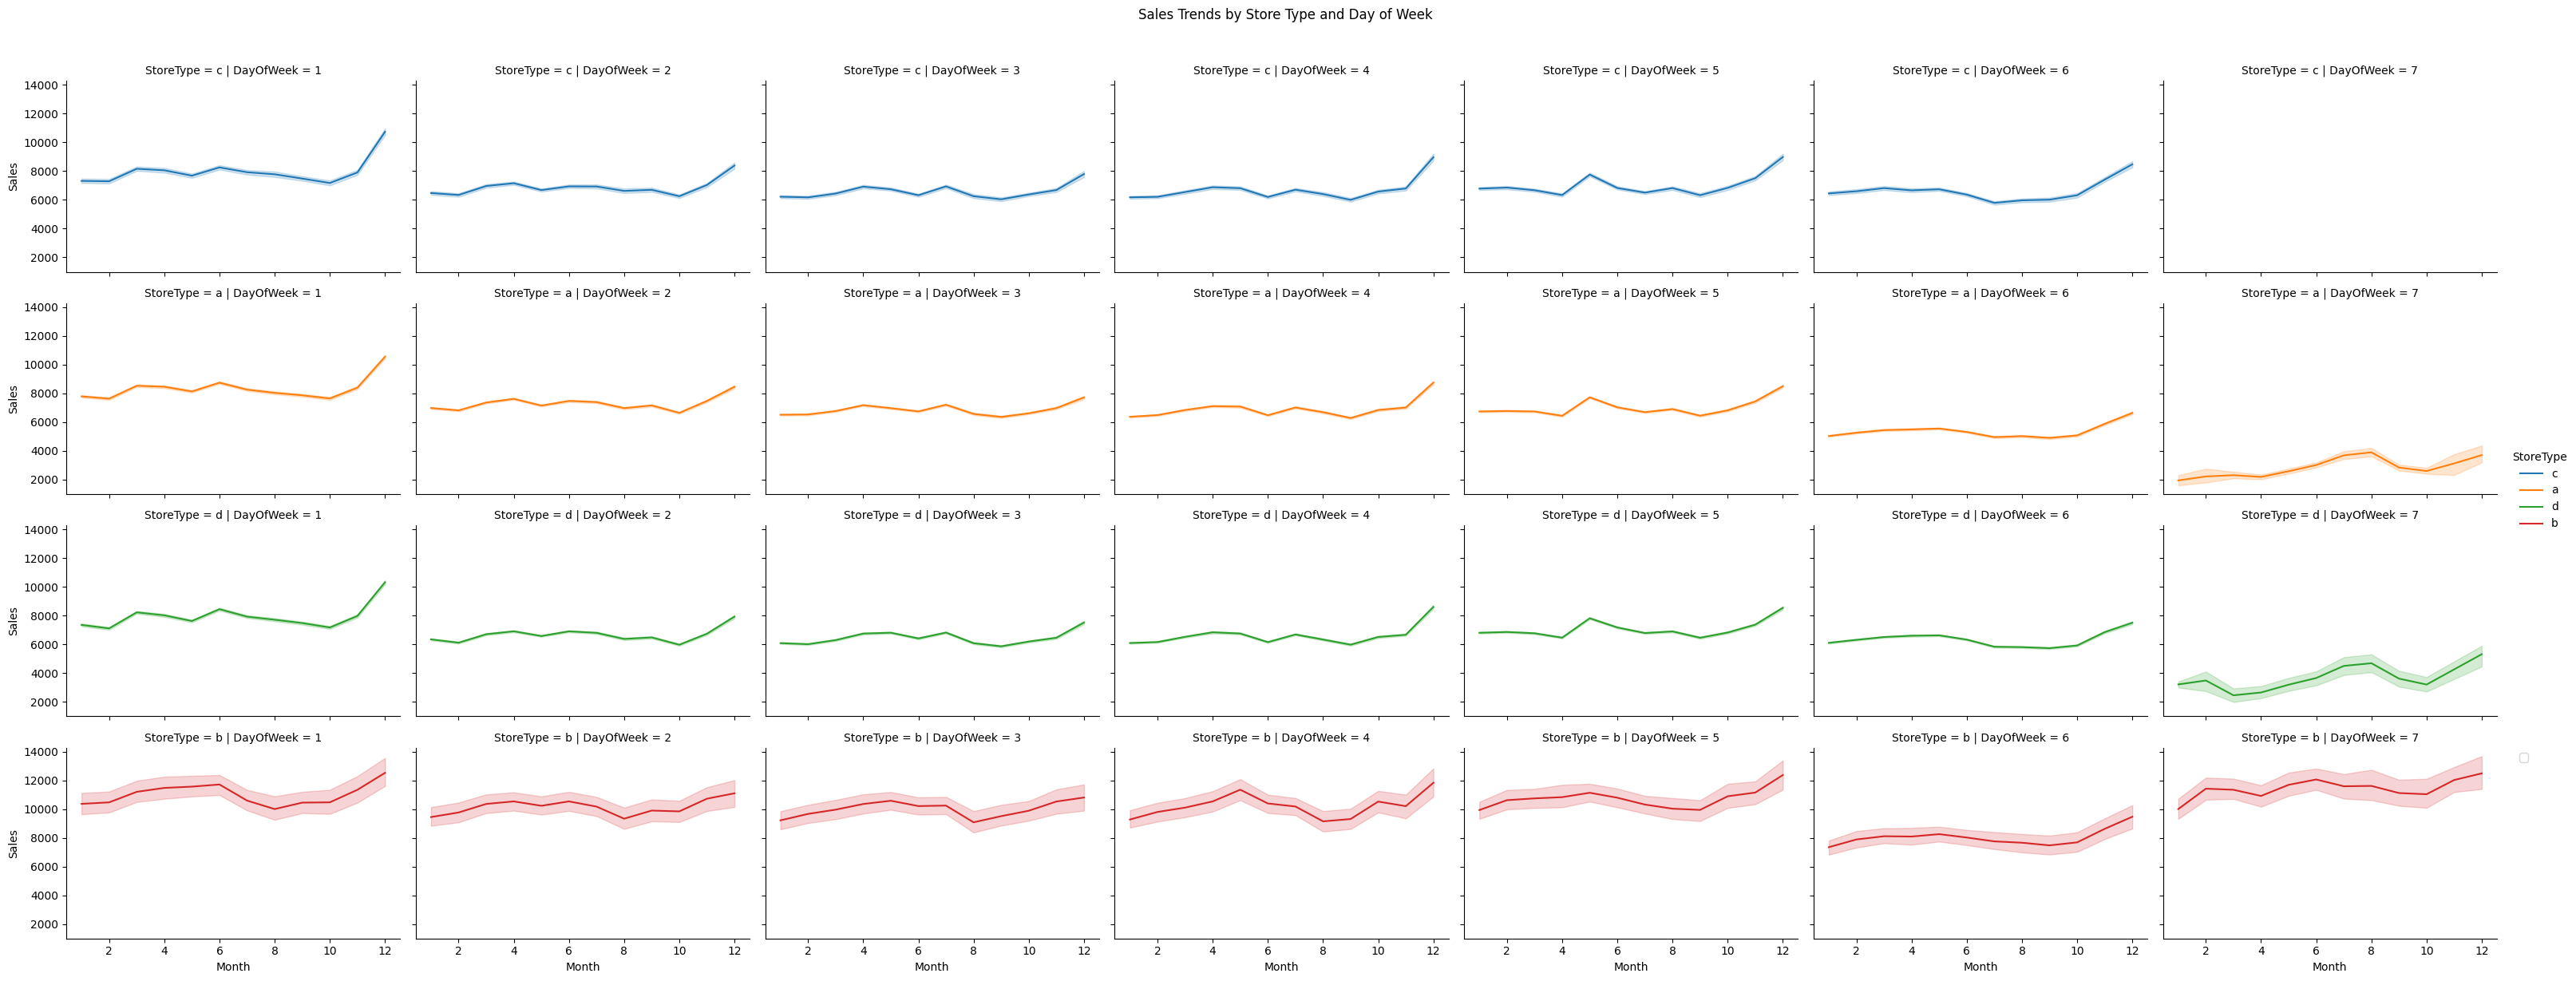

In [52]:
# Create relplot for Sales by DayOfWeek and StoreType
plt.figure(figsize=(20, 15))
sns.relplot(data=train_store, 
            x='Month', 
            y='Sales',
            col='DayOfWeek',
            row='StoreType',
            hue='StoreType',
            kind='line',
            height=3,
            aspect=1.5)

plt.suptitle('Sales Trends by Store Type and Day of Week', y=1.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.97)
plt.show()

/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/1282242000.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


<Figure size 2000x1500 with 0 Axes>

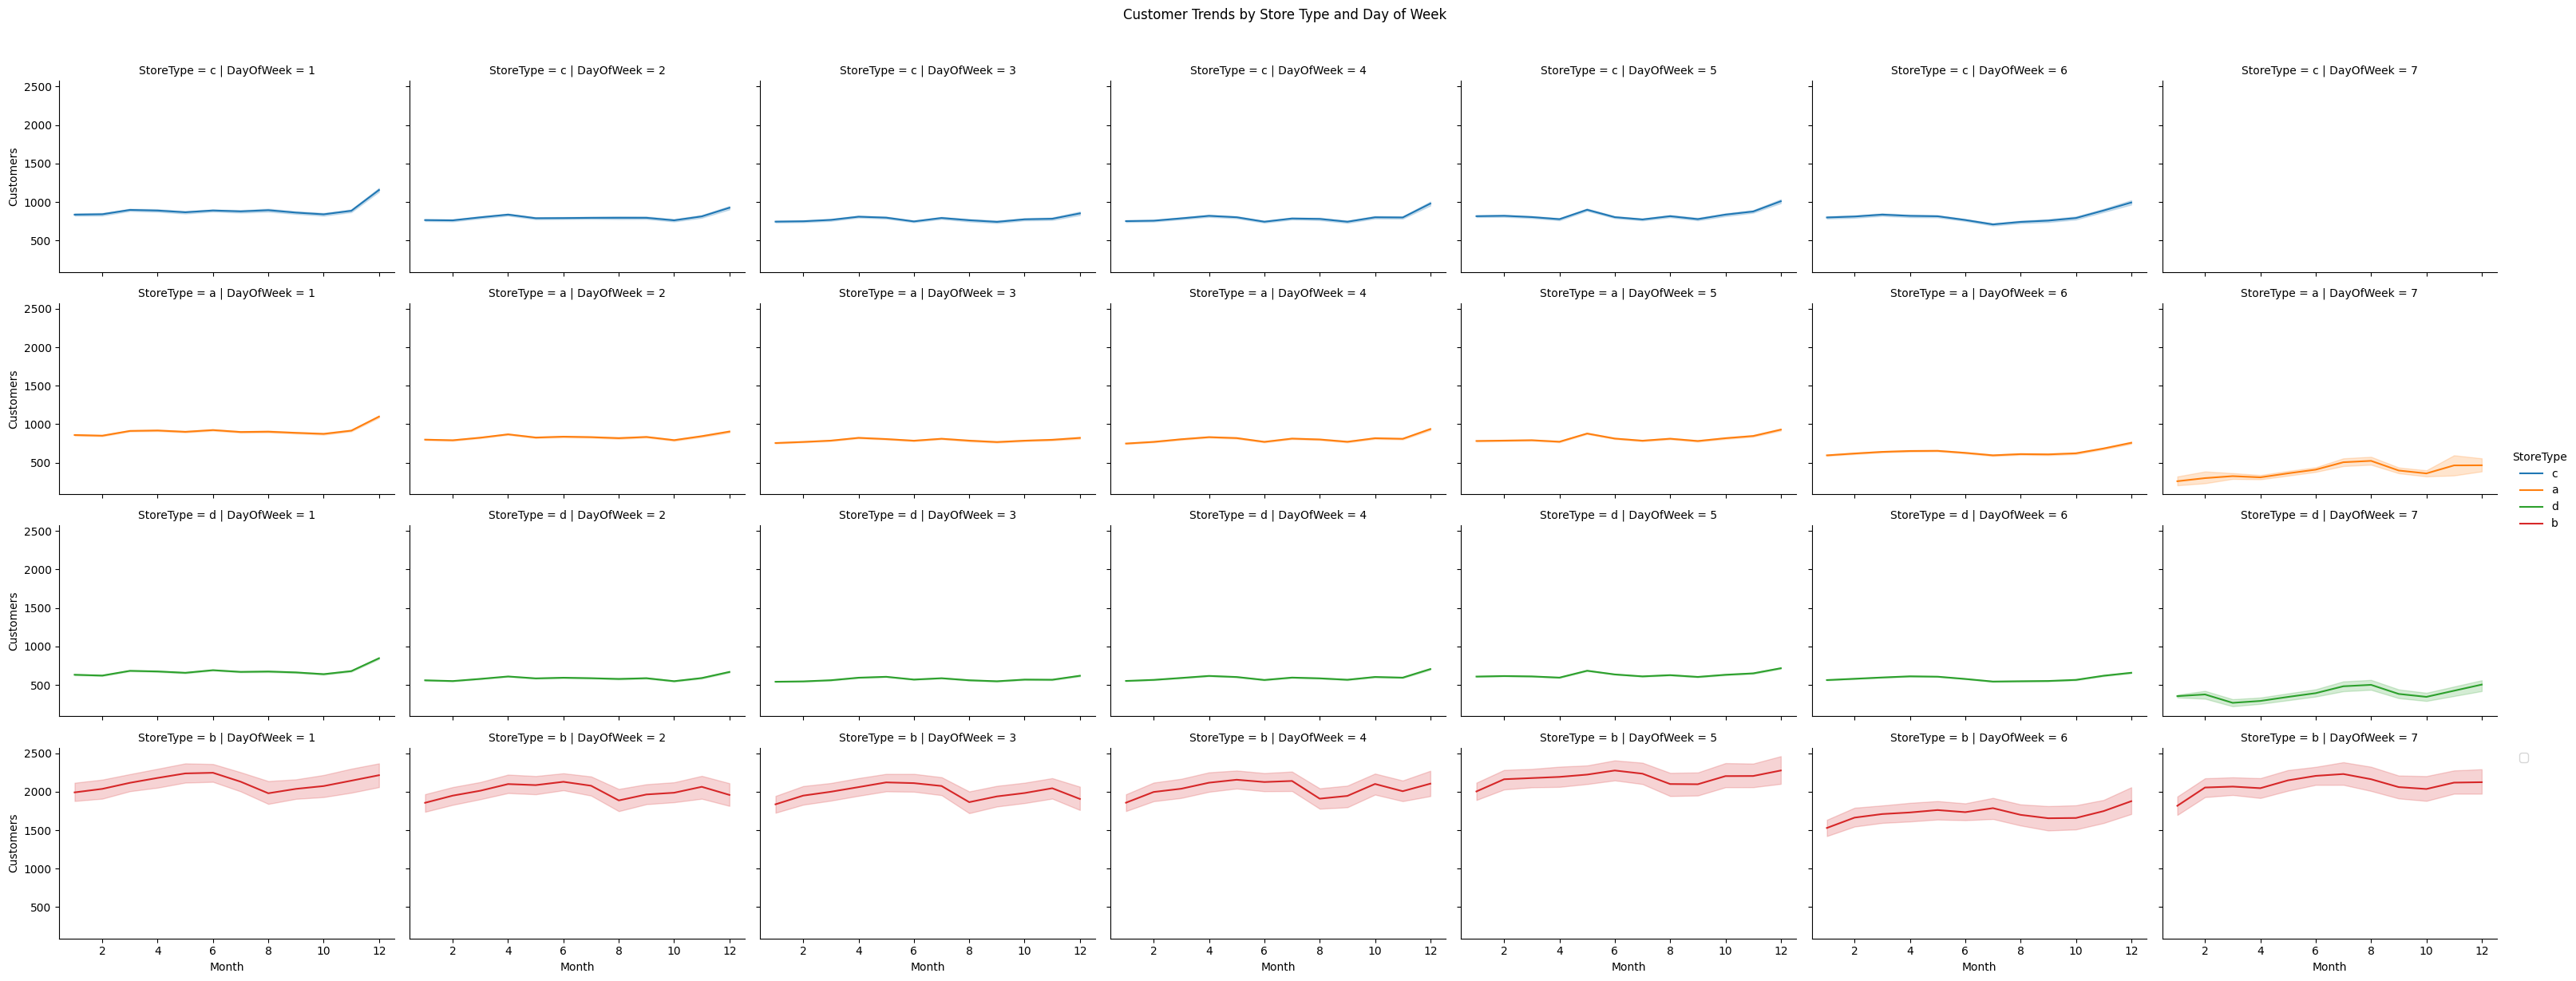

In [54]:
# Create relplot for Customers by DayOfWeek and StoreType
plt.figure(figsize=(20, 15))
sns.relplot(data=train_store, 
            x='Month', 
            y='Customers',
            col='DayOfWeek',
            row='StoreType',
            hue='StoreType',
            kind='line',
            height=3,
            aspect=1.5)

plt.suptitle('Customer Trends by Store Type and Day of Week', y=1.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.97)
plt.show()

/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/1712036339.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


<Figure size 2000x1500 with 0 Axes>

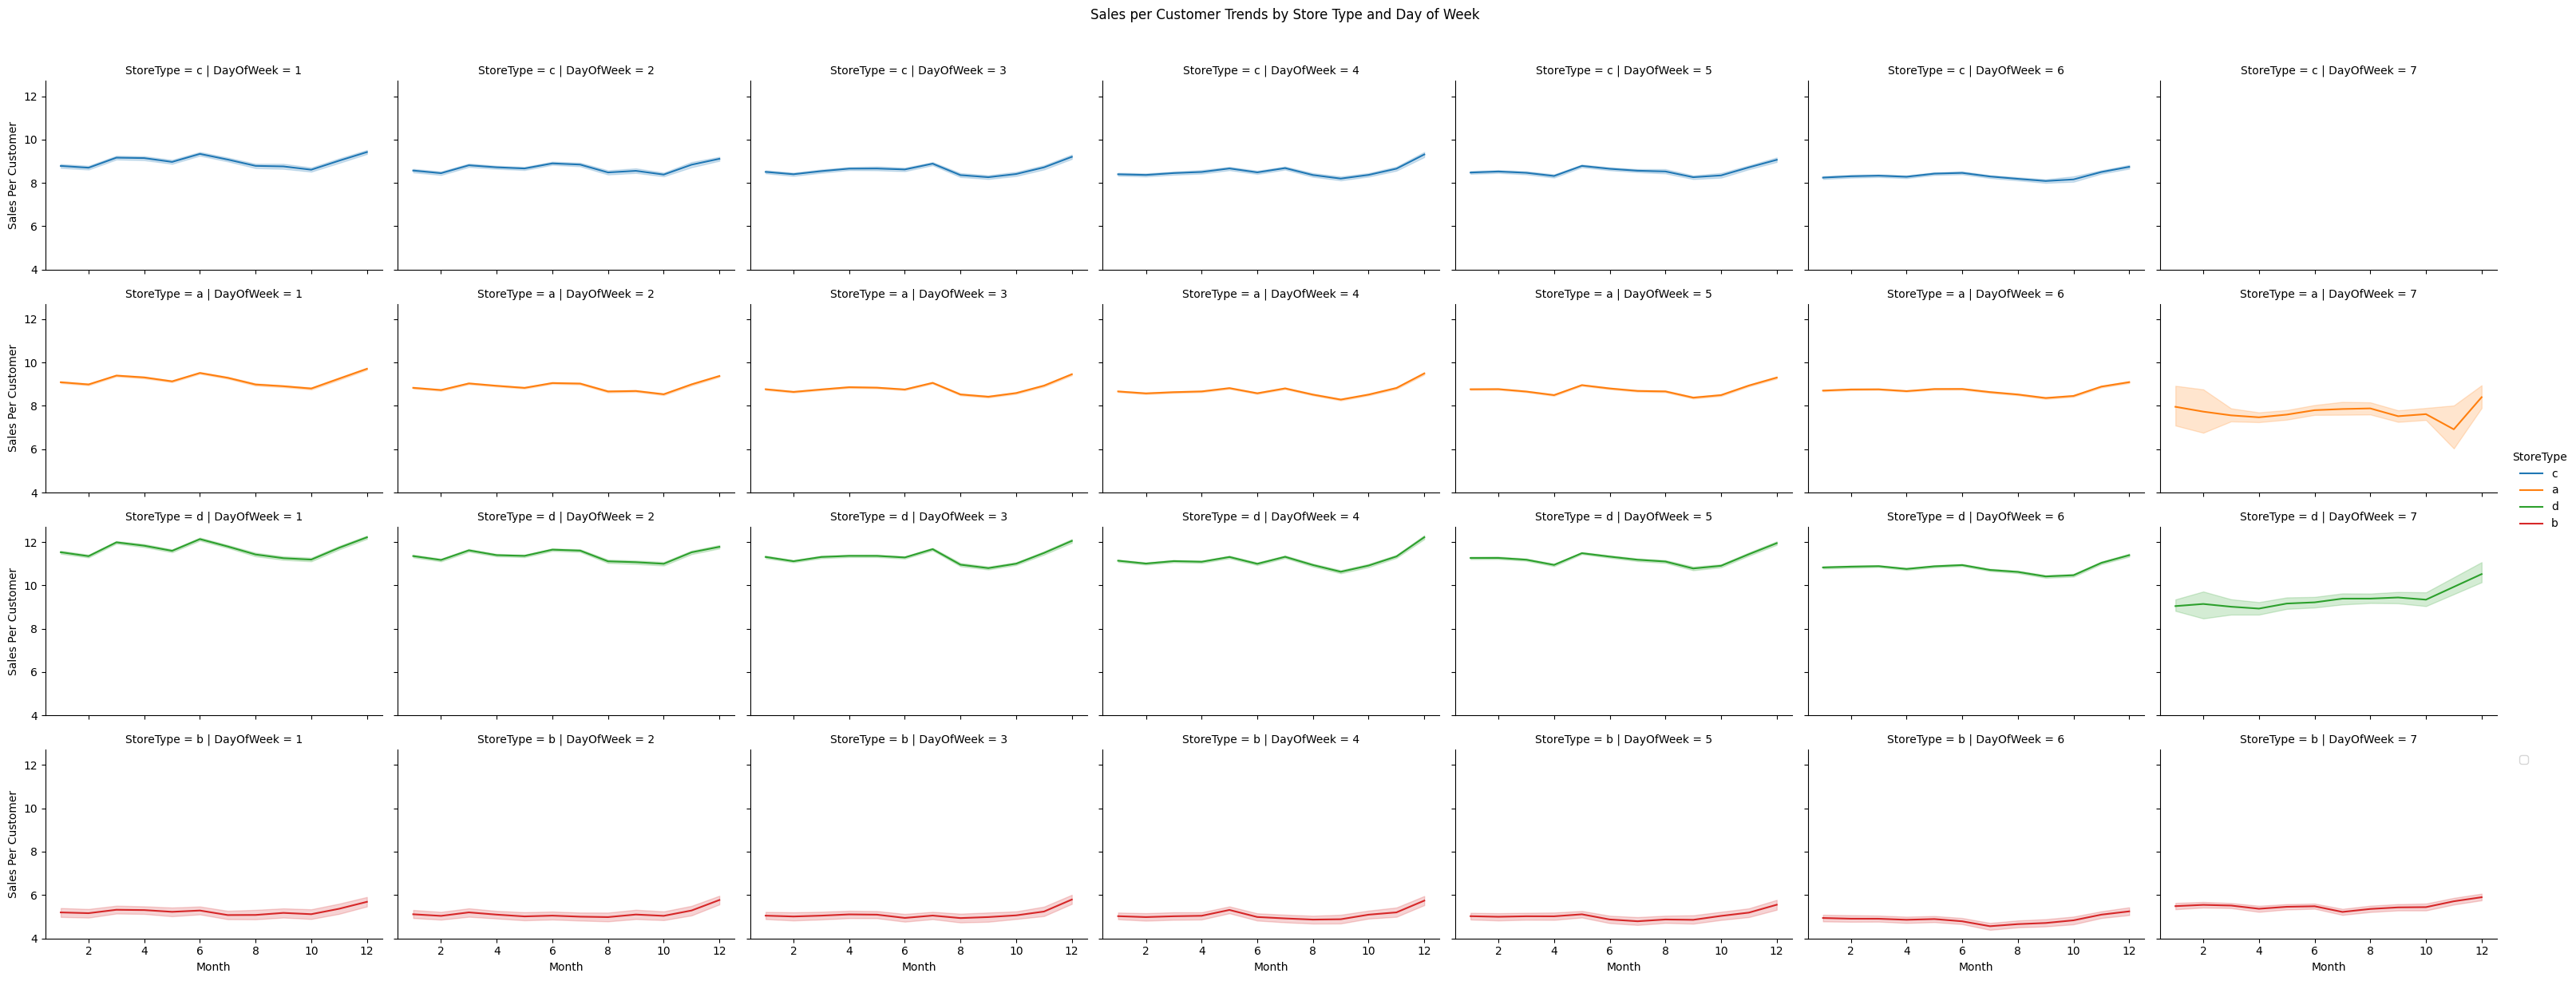

In [55]:
# Create relplot for Sales per Customer by DayOfWeek and StoreType
plt.figure(figsize=(20, 15))
sns.relplot(data=train_store, 
            x='Month', 
            y='Sales Per Customer',
            col='DayOfWeek',
            row='StoreType',
            hue='StoreType',
            kind='line',
            height=3,
            aspect=1.5)

plt.suptitle('Sales per Customer Trends by Store Type and Day of Week', y=1.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.97)
plt.show()

1. As we can see in these graphs above, Store type b has the highest amount of Sales and Customers, but the lowest Sales per Customers. This demonstrate the low price good buckets of store type b.
2. Store type c is not open on Sunday and has zero sales.
3. The number of customers for store type a and d on Sunday decreases significantly.

<h3>2. Sales Distribution based on Assortment Type<h3>

In [56]:
train_store.groupby('Assortment')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Assortment,,,,,,,,
a,437767.0,6624.226991,2974.792303,46.0,4612.0,6084.0,8003.0,38722.0
b,8083.0,8629.549425,3811.525220,1580.0,5589.5,8054.0,11258.0,22137.0
c,385068.0,7297.878712,3185.614522,133.0,5153.0,6672.0,8699.0,41551.0


/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/1832343927.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


<Figure size 2000x1500 with 0 Axes>

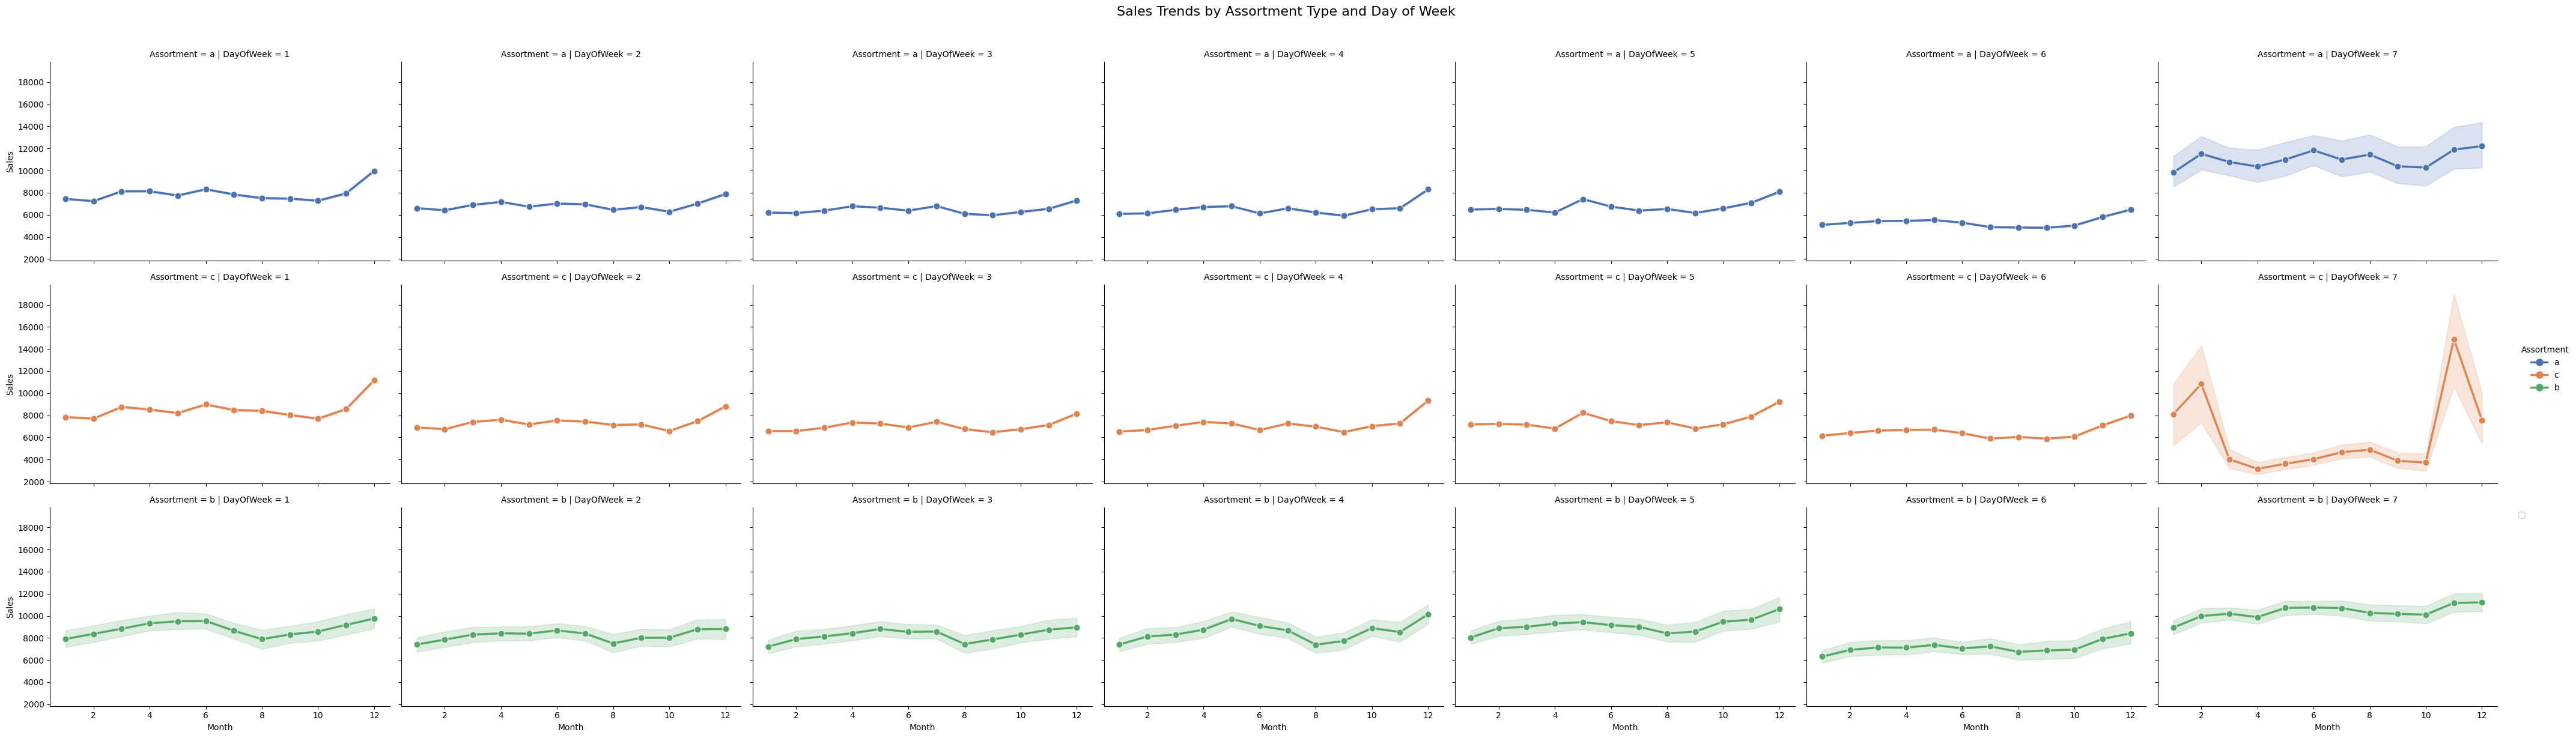

In [59]:
plt.figure(figsize=(20, 15))
sns.relplot(data=train_store,
            x='Month', 
            y='Sales',
            col='DayOfWeek',
            row='Assortment',
            hue='Assortment',
            kind='line',
            marker='o',
            markersize=8,
            height=4,
            aspect=1.5,
            palette='deep',
            linewidth=2.5,
            col_wrap=None,
            style='Assortment',
            dashes=False)

plt.suptitle('Sales Trends by Assortment Type and Day of Week', y=1.02, fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.97)

Assortment type a and b has higher sales volumns on Sunday, with type a rose more significantly. In contrast, assortment type c has huge dip on Sunday, especially from March to October.

<h3>3. Promotion effect on Sales<h3>

In [60]:
promo_effect = train_store.groupby('Promo')['Sales'].describe()
promo_effect

,count,mean,std,min,25%,50%,75%,max
Promo,,,,,,,,
0,459608.0,5930.760174,2632.152046,46.0,4241.0,5458.0,7005.0,41551.0
1,371310.0,8224.866993,3177.846341,133.0,6064.0,7644.0,9682.0,38722.0


Text(0.5, 1.0, 'Sales Distribution by Promo')

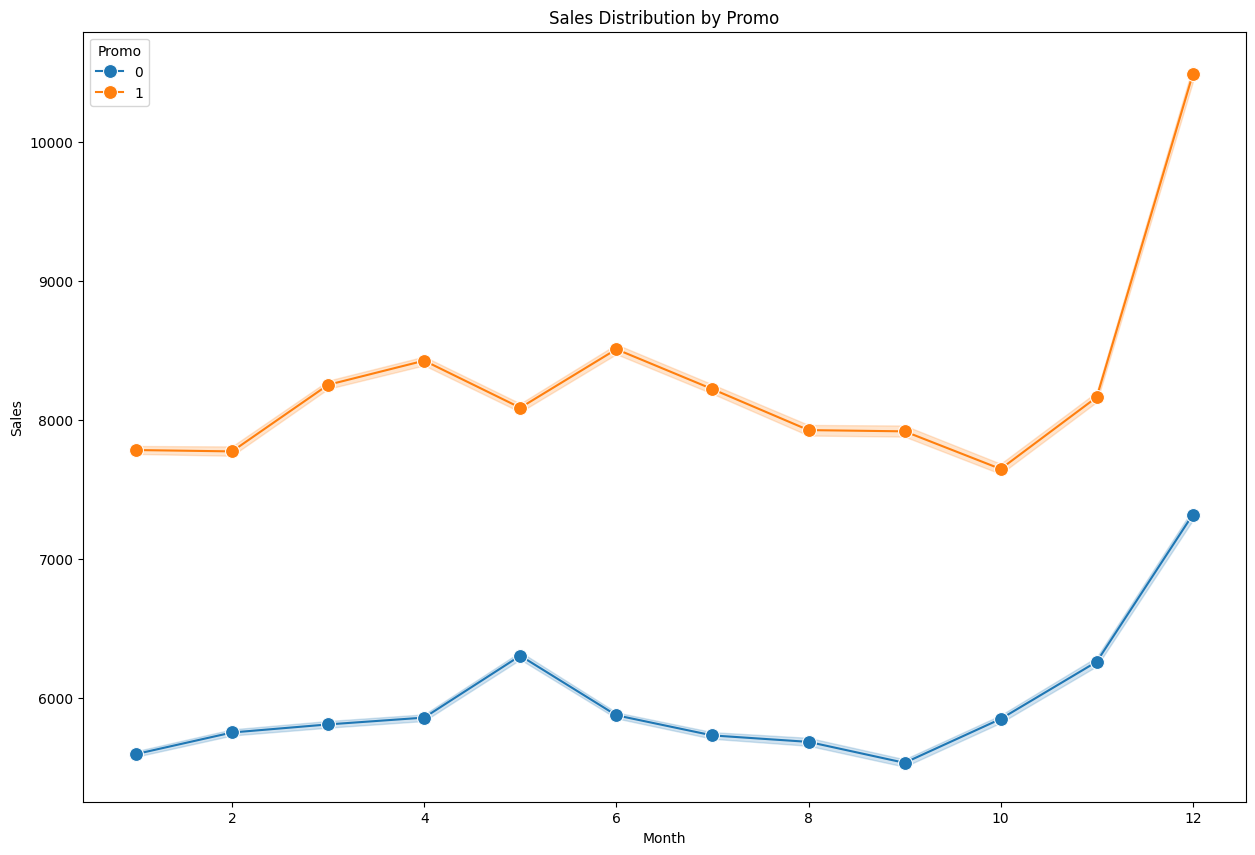

In [62]:
plt.figure(figsize=(15,10))
#Line plot of sales by promo
sns.lineplot(data=train_store,
             x='Month',
             y='Sales',
             hue='Promo',
            marker='o',
            markersize=10,
             )
plt.title('Sales Distribution by Promo')

As we can see, Promo has clear and concise effect on the sales volumns overall. Now we will take a look at how promo has impact on each store type and assortment type.

/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/1119005011.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


<Figure size 1500x1000 with 0 Axes>

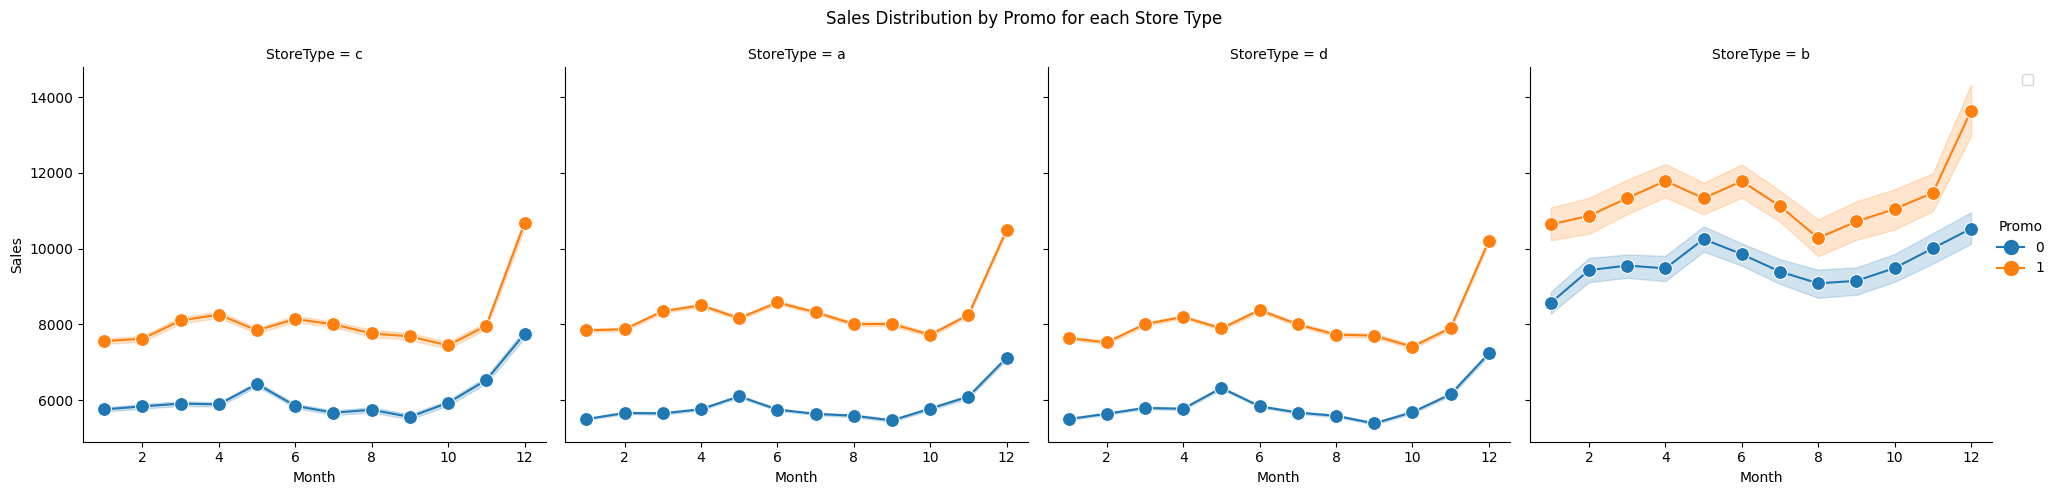

In [65]:
#The Effect of Promo on Sales by Store Type
plt.figure(figsize=(15,10))

sns.relplot(data=train_store,
            x='Month',
            y='Sales',
            col='StoreType',
            hue='Promo',
            kind='line',
            marker='o',
            markersize=10,
)

plt.suptitle('Sales Distribution by Promo for each Store Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.97)

/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/3859003591.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


<Figure size 1500x1000 with 0 Axes>

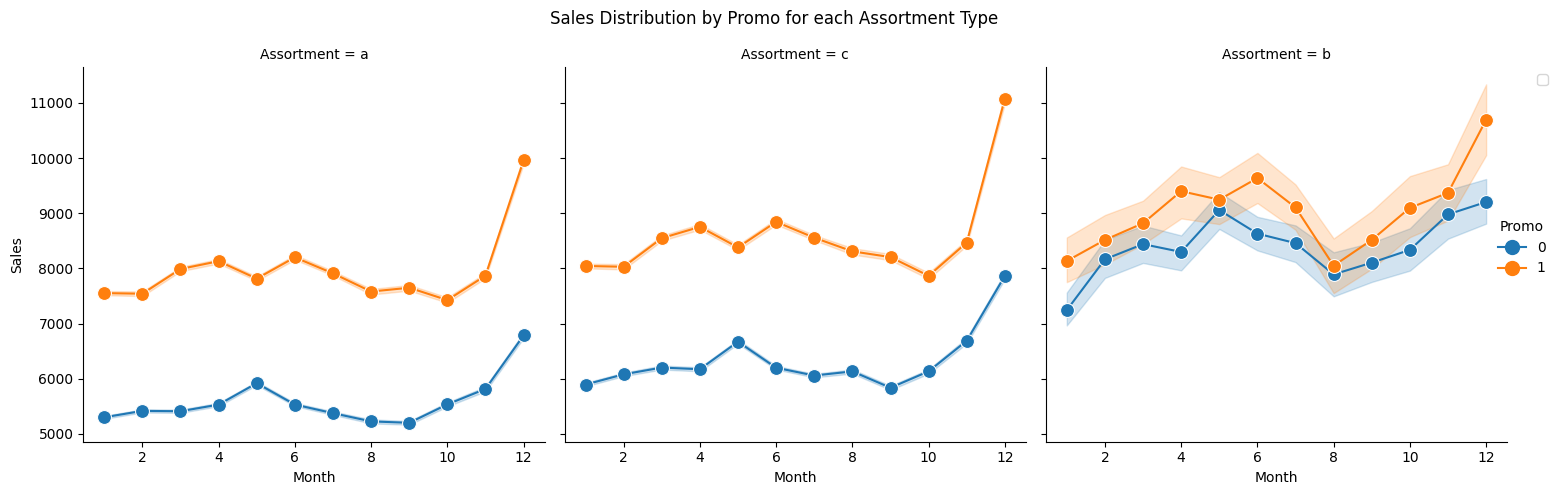

In [66]:
#Sales Distribution by Promo for each Assortment Type
plt.figure(figsize=(15,10))

sns.relplot(data=train_store,
            x='Month',
            y='Sales',
            col='Assortment',
            hue='Promo',
            kind='line',
            marker='o',
            markersize=10,
)

plt.suptitle('Sales Distribution by Promo for each Assortment Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.97)

As we can see, for each StoreType, Promo has clear and concise effect, which helps sales volumn increase. However, for Assortment type, Assortment type a and c demonstrate clear increase in sales when having promotion, while assortment b does not seem to have a significant impact on sales when applying promotion campaign. Managers can consider cut out the promotion for store type b from January to October, just keep the December campaign for this assortment type.

Now we will look at the effect of Promo2 on sales volumn

Text(0.5, 1.0, 'Sales distribution by Promo2')

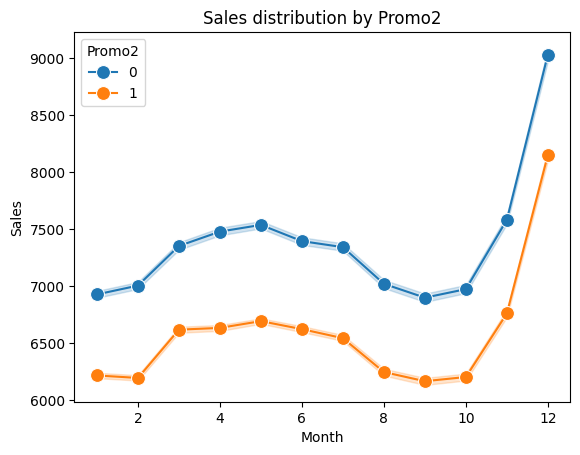

In [67]:
#Sales Distribution by Promo2
sns.lineplot(data=train_store,
            x='Month',
            y='Sales',
            hue='Promo2',
            marker='o',
            markersize=10
)

plt.title('Sales distribution by Promo2')

/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/1959522560.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


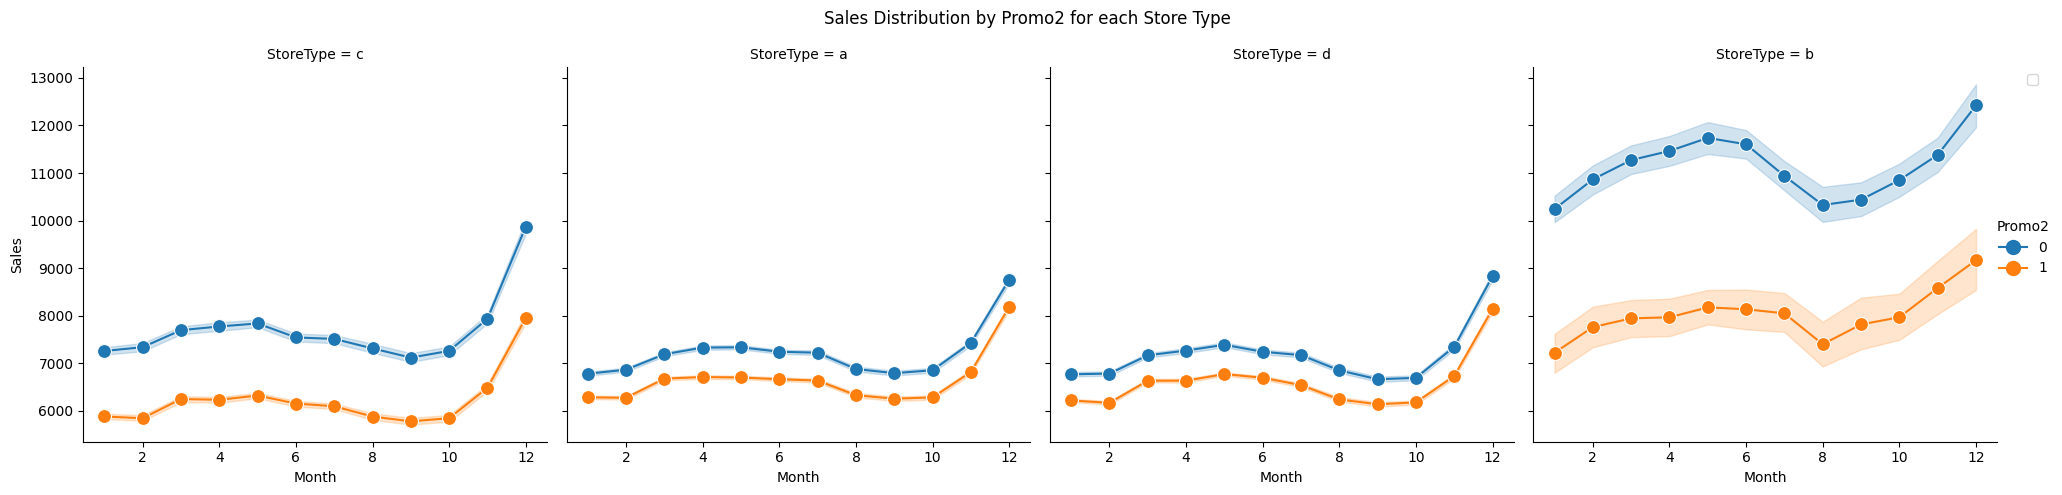

In [68]:
#Sales Distribution by Promo2 for each Store Type
sns.relplot(data=train_store,
            x='Month',
            y='Sales',
            col='StoreType',
            hue='Promo2',
            kind='line',
            marker='o',
            markersize=10)
plt.suptitle('Sales Distribution by Promo2 for each Store Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.subplots_adjust(right=0.97)

Promo2 causes sales to decrease, managers can consider cut out the promotion 2 because it does not help anything

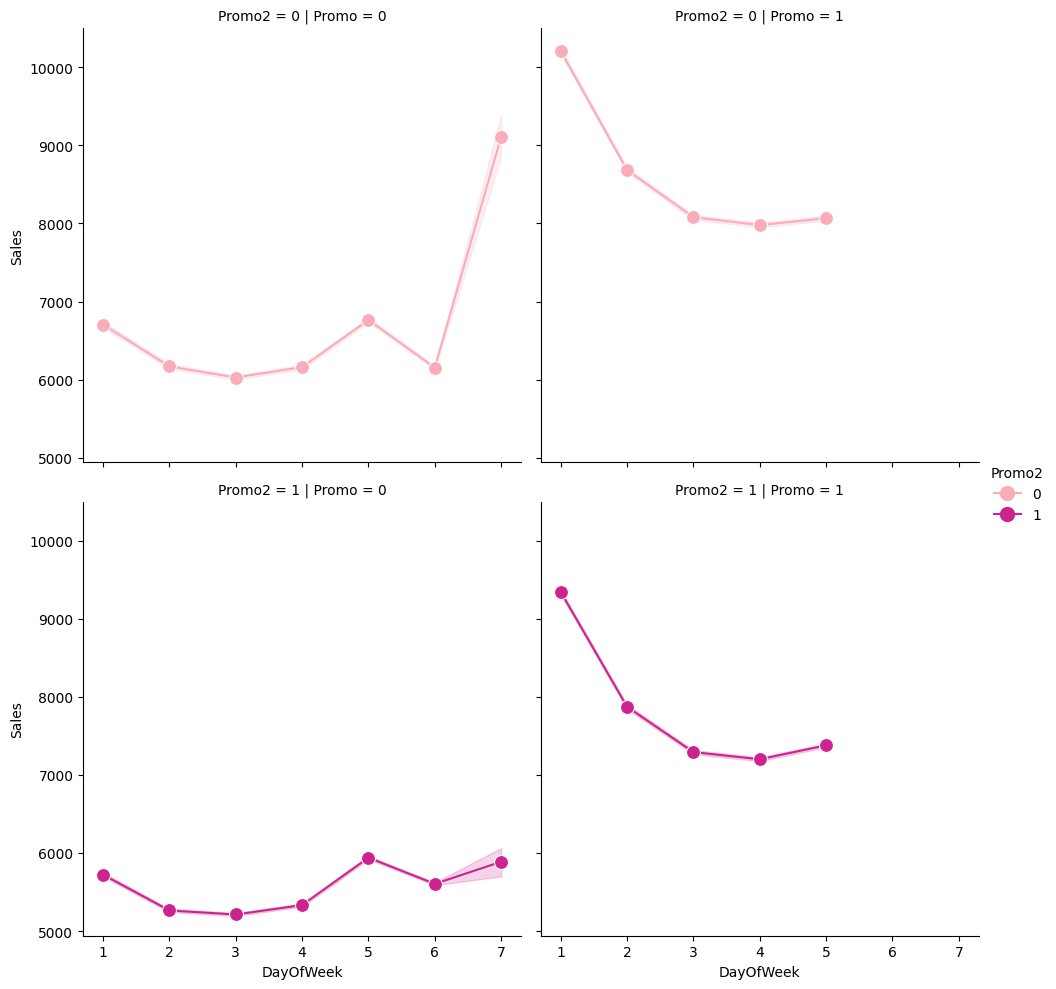

In [109]:
# sale per customer trends
sns.relplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               kind='line',
               marker='o',
               markersize=10,
               palette = 'RdPu') 

Solely apply promo2 actually causes sales to decrease compared to not apply any promo at all (promo=0, promo2=0). Applying promo2 after promo 1 (promo=1, promo2=1) also lower sales compared to just apply the first promo (promo=1). Managers should consider getting rid of promo2 to cut cost.

<h3>4. Competition Effect on Sales<h3>

In [69]:
# Statistical summary of sales by competition distance ranges
train_store['CompetitionDistance_Ranges'] = pd.qcut(train_store['CompetitionDistance'], 
                                                   q=5, 
                                                   labels=['Very Close', 'Close', 'Medium', 'Far', 'Very Far'])

In [70]:
train_store.groupby('CompetitionDistance_Ranges')['Sales'].describe()

/var/folders/h_/vq59lwtj37v8fx1btkpd82k00000gn/T/ipykernel_26060/2232692663.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_store.groupby('CompetitionDistance_Ranges')['Sales'].describe()


,count,mean,std,min,25%,50%,75%,max
CompetitionDistance_Ranges,,,,,,,,
Very Close,166813.0,7601.314634,3706.696590,530.0,5062.0,6783.0,9221.0,38037.0
Close,166928.0,6847.692239,3429.980423,506.0,4577.0,6107.0,8148.0,38722.0
Medium,165181.0,6698.535976,2789.318566,297.0,4749.0,6195.0,8094.0,41551.0
Far,166175.0,6802.527065,2561.702941,316.0,4991.0,6401.0,8171.0,28242.0
Very Far,165821.0,6825.732030,2793.926385,46.0,4937.0,6393.0,8280.0,37646.0


([0, 1, 2, 3, 4],
 [Text(0, 0, 'Very Close'),
  Text(1, 0, 'Close'),
  Text(2, 0, 'Medium'),
  Text(3, 0, 'Far'),
  Text(4, 0, 'Very Far')])

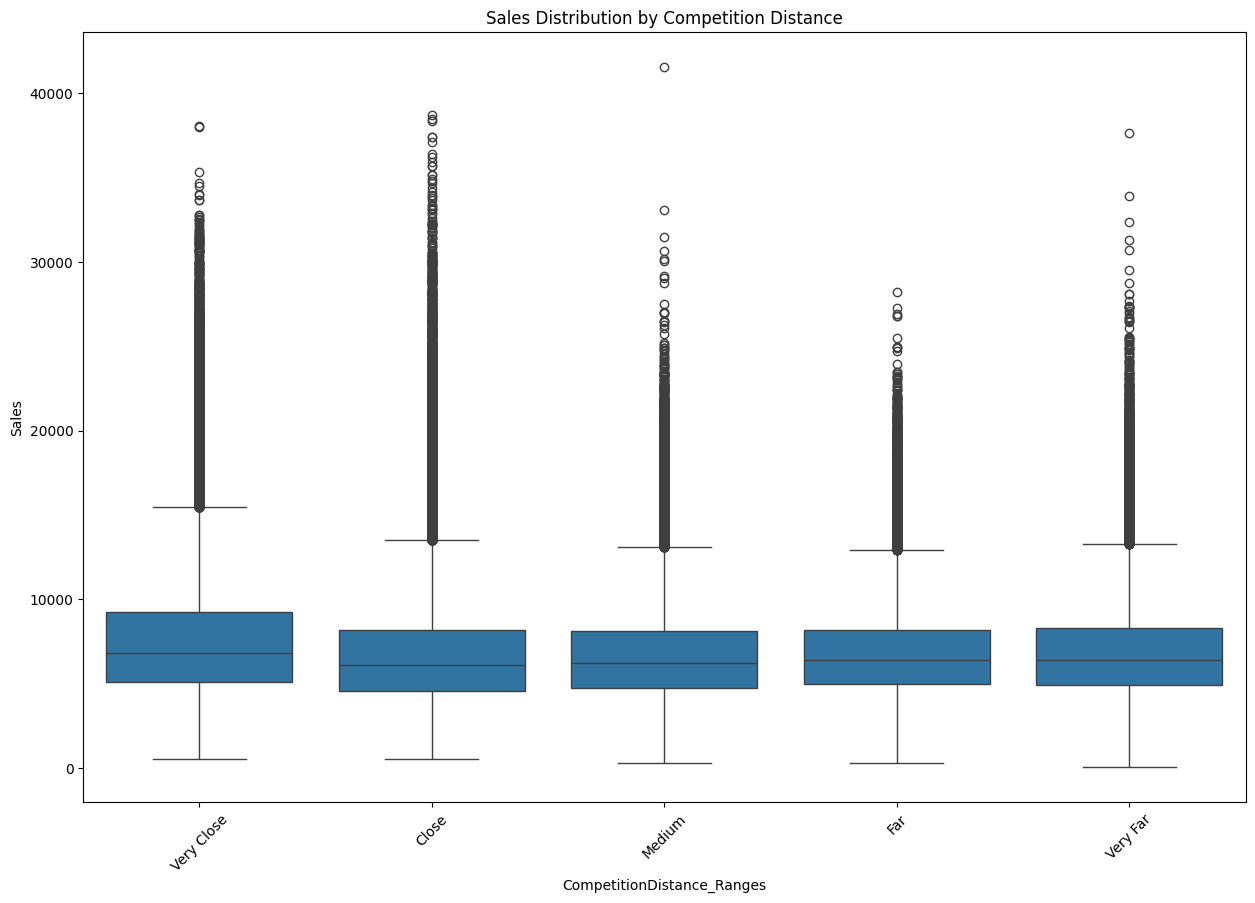

In [71]:
plt.figure(figsize=(15, 10))

#Box plot of sales by competition distance ranges
sns.boxplot(data=train_store, 
           x='CompetitionDistance_Ranges', 
           y='Sales')
plt.title('Sales Distribution by Competition Distance')
plt.xticks(rotation=45)

There's not much differences in sales for each category of competition distance. Therefore, this variable does not have much impact on sales volumn for each store.

<h3>Summary of EDA<h3>

Store type b has the highest sales volumns and customers compared to the others, but has the lowest sales per customer.

Sales tend to bust at the end of the year (November/December).

On the weekend, store type a and d demonstrate significant drop in sales.

Assortment a and c shows slight increase on Sunday, while assortment b has signficant decrease in sales this day.

Promo has huge impact on sales, helped to increase nearly 50% sales volumns through out the year. However, Assortment b does not seem to have a significant impact on sales when applying promotion campaign. Managers can consider cut out the promotion for store type b from January to October, just keep the December campaign for this assortment type.

Promo2 does not show any clear and concise impact on sales. It even decreases the number of sales throughout the year. Should consider to eliminate promo2.

Competition Distance does not have any significant impact on sales.

Now we are done with the EDA part and get to understand basic characteristics of the dataset. We now will move on to time series decompostition and forecasting future for Rossman stores.

<h2>IV. TIME SERIES DECOMPOSITION<h2>

First we need to decompose the time series to understand its trend, seasonality, holiday. We can use Prophet method to decompose the time series with 3 elements: trend, seasonality, and holiday.

First, we will take a look at the original time series data

<Axes: xlabel='Date', ylabel='Sales'>

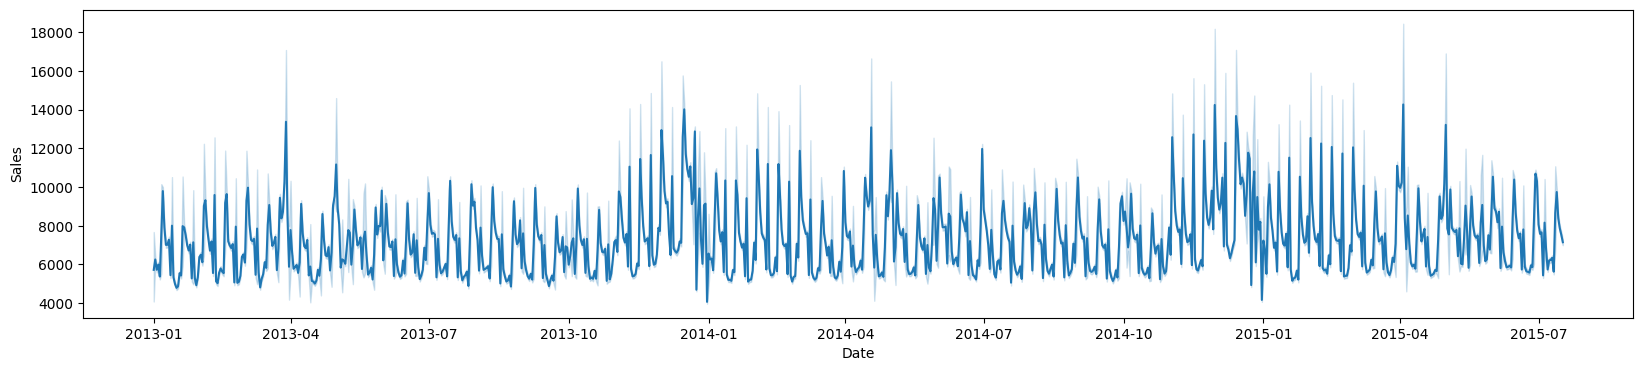

In [72]:
plt.figure(figsize=(20,4))
sns.lineplot(data=train_store, x='Date', y='Sales')

From the visualization of the original time series data, we can see that this is suitable for additive decomposition because the magnitude of seasonality does not change with the magnitude of the time series

It is reasonable to downsample the data from daily to weekly to easily see the present trends and seasonality

In [74]:
daily_sales

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-13    10841267
2015-07-14     9340405
2015-07-15     8756137
2015-07-16     8373873
2015-07-17     7949337
Name: Sales, Length: 928, dtype: int64

In [78]:
weekly_sales

Date
2013-01-06    26129335
2013-01-13    49275222
2013-01-20    34377765
2013-01-27    46040169
2013-02-03    38466029
                ...   
2015-06-21    53115445
2015-06-28    38749768
2015-07-05    55690481
2015-07-12    41391282
2015-07-19    45261019
Freq: W-SUN, Name: Sales, Length: 133, dtype: int64

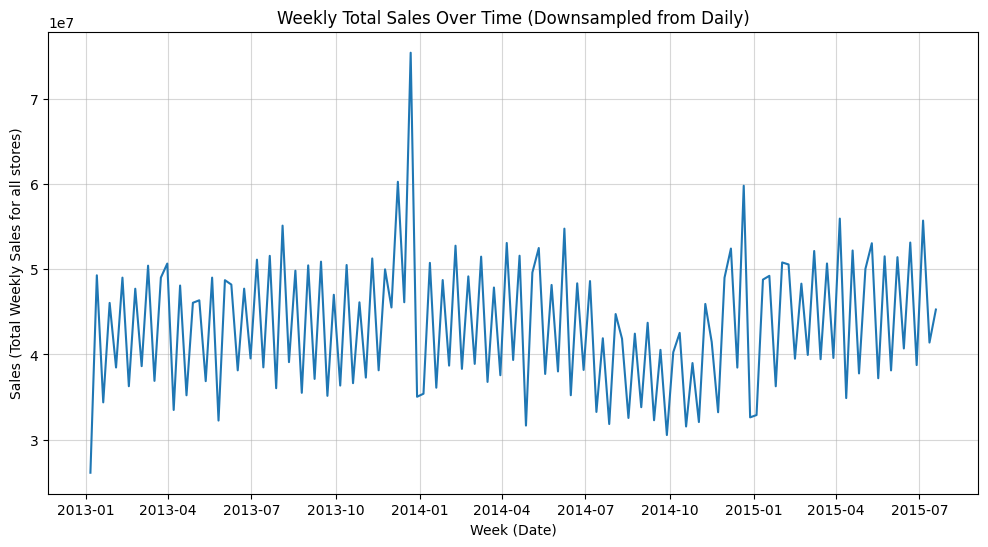


First few rows of weekly sales data:
Date
2013-01-06    26129335
2013-01-13    49275222
2013-01-20    34377765
2013-01-27    46040169
2013-02-03    38466029
Freq: W-SUN, Name: Sales, dtype: int64


In [79]:
# Aggregate daily sales across all stores
daily_sales = train_store.groupby('Date')['Sales'].sum() # Groupby and sum, result is a Series with Date as index

# Resample daily sales to weekly sales
weekly_sales = daily_sales.resample('W').sum() # 'W' for weekly frequency, sum aggregation

# Create the plot for weekly sales
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales)
plt.title('Weekly Total Sales Over Time (Downsampled from Daily)')
plt.xlabel('Week (Date)')
plt.ylabel('Sales (Total Weekly Sales for all stores)')
plt.grid(True, alpha=0.5)
plt.show()

print("\nFirst few rows of weekly sales data:")
print(weekly_sales.head())

From the weekly total sales over time, we can see a clear seasonality at the end of the year (November/December), maybe due to Christmas season. We will take a closer look at each decomposition variable: Trend, Seasonality, and Residual now to understand more

Because we have the daily/weekly time series data --> We would use classical decomposition method

In [81]:
#import libraries
from statsmodels.tsa.seasonal import seasonal_decompose

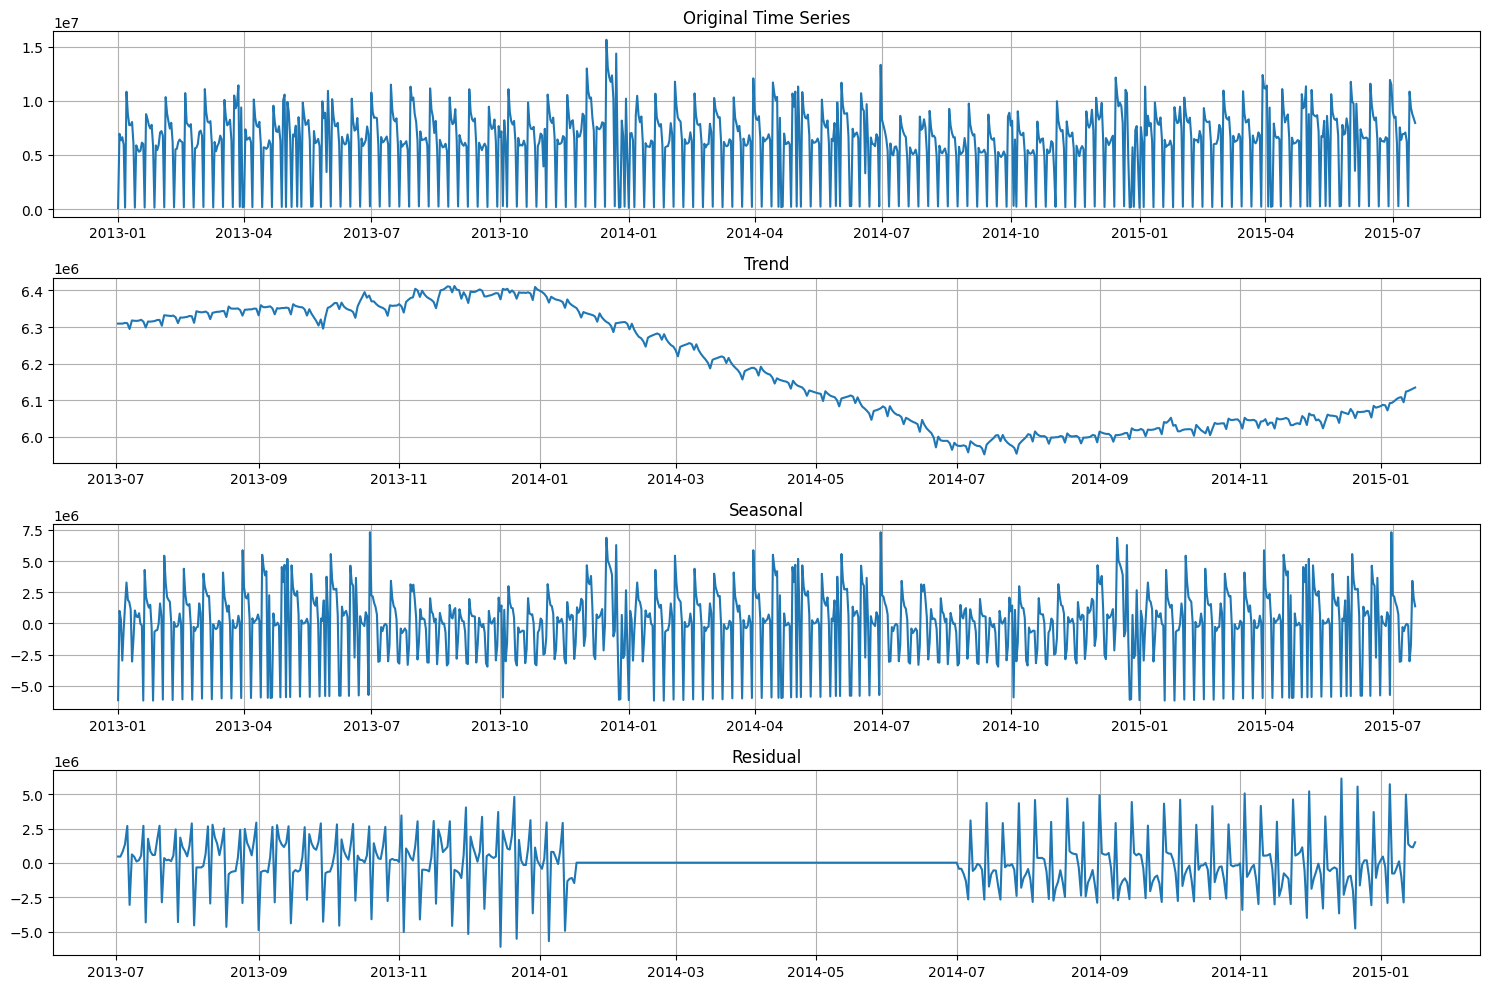

In [86]:
train_store = train_store.reset_index().set_index('Date')

#We wanna see the yearly pattern so we set the period=365
classical_decomposition = seasonal_decompose(x=daily_sales, period=365, model='additive')


plt.figure(figsize=(15,10))
#Plot original data
plt.subplot(411)
plt.plot(daily_sales)
plt.title('Original Time Series')
plt.grid(True)

# Plot trend component
plt.subplot(412)
plt.plot(classical_decomposition.trend)
plt.title('Trend')
plt.grid(True)

# Plot seasonal component
plt.subplot(413)
plt.plot(classical_decomposition.seasonal)
plt.title('Seasonal')
plt.grid(True)

# Plot residual component
plt.subplot(414)
plt.plot(classical_decomposition.resid)
plt.title('Residual')
plt.grid(True)

plt.tight_layout()
plt.show()

The yearly seasonality with daily sales data is not easy to intepret so now we will try the yearly seasonality with weekly sales data

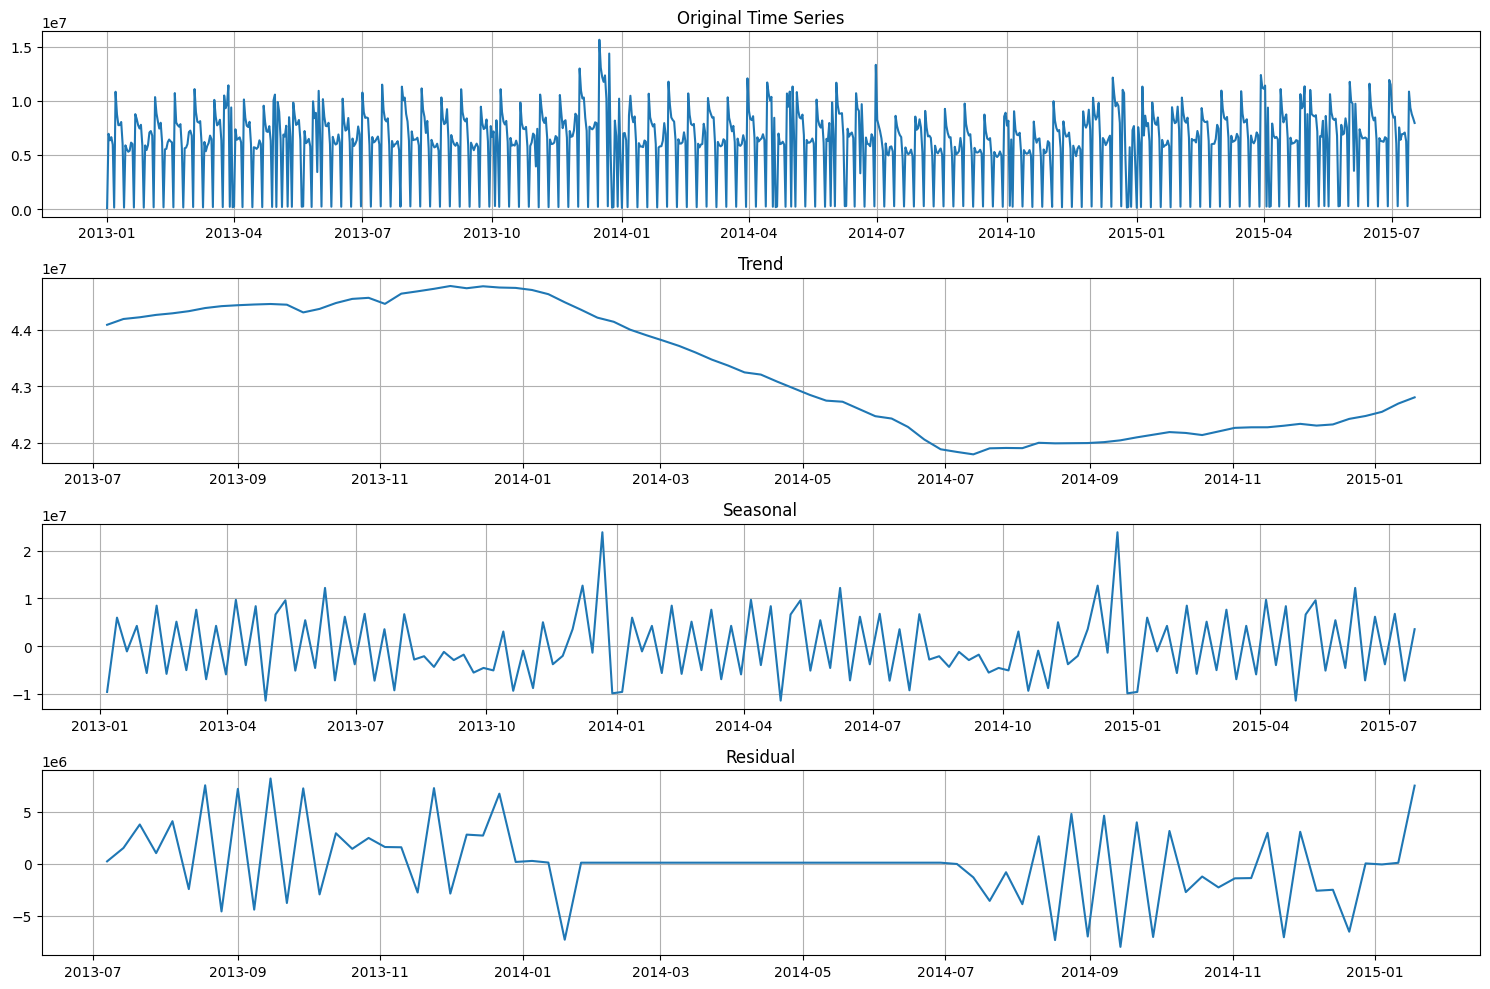

In [87]:
#We wanna see the yearly pattern so we set the period=365
classical_decomposition = seasonal_decompose(x=weekly_sales, period=52, model='additive')


plt.figure(figsize=(15,10))
#Plot original data
plt.subplot(411)
plt.plot(daily_sales)
plt.title('Original Time Series')
plt.grid(True)

# Plot trend component
plt.subplot(412)
plt.plot(classical_decomposition.trend)
plt.title('Trend')
plt.grid(True)

# Plot seasonal component
plt.subplot(413)
plt.plot(classical_decomposition.seasonal)
plt.title('Seasonal')
plt.grid(True)

# Plot residual component
plt.subplot(414)
plt.plot(classical_decomposition.resid)
plt.title('Residual')
plt.grid(True)

plt.tight_layout()
plt.show()

It is clear that the yearly seasonality with the weekly data is more easy to interpret, so we will stick with this. 

From the plot above, we recognize a cyclical trend, with the peak at the beginning of 2014 and the trough at Juy 2014 and an increasing trend afterwards. 

In the seasonal plot, we can see that there is higher sales at the end of the year (November and December), maybe due to the Christmas season. Moreover, the troughs (lowest points) seem to occur in the middle of the year (around summer).

Actionable Insight: This yearly seasonal pattern is very valuable for planning inventory, staffing, and promotions. Managers should know to expect a significant sales surge at the end of the year and a slower period in mid-year.

Now that we have done the time series decomposition. We will move on to forecasting future sales using Prophet method.

<h2>V. PROPHET FORECASTING<h2>

In [84]:
# prophet by Facebook
from prophet import Prophet

<h4>Create Holiday Dataframe<h4>

Our workflow to create the holiday dataframe is like this:

**Step 1:** Extract holiday dataframe (including ds and holiday) for each store

    - Get StateHoliday & SchoolHoliday from the train dataset
    - Get Holiday from the test dataset

**Step 2:** Put them into a new empty dataframe (df_holiday)\
**Step 3:** Create group for each store by groupby function\
**Step 4:** Loop through each store when fitting the model

In [103]:
#Transforming StateHoliday dtype because it has 2 types of 0
df_train['StateHoliday'] = df_train['StateHoliday'].astype(str)
df_train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [104]:
#Load the test dataset
df_test = pd.read_csv('test.csv')
df_test

,Id,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,879066,1,5,2015-07-31,555,1,1,0,1
1,37135,2,5,2015-07-31,625,1,1,0,1
2,285919,3,5,2015-07-31,821,1,1,0,1
3,744348,4,5,2015-07-31,1498,1,1,0,1
4,556250,5,5,2015-07-31,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1110,225022,1111,5,2015-07-31,422,1,1,0,1
1111,244217,1112,5,2015-07-31,767,1,1,0,1
1112,729063,1113,5,2015-07-31,720,1,1,0,1
1113,321477,1114,5,2015-07-31,3745,1,1,0,1


In [105]:
df_test.StateHoliday.unique()

array([0])

In [106]:
df_test.SchoolHoliday.unique()

array([1, 0])

In [107]:
df_test_holidays = df_test[df_test['SchoolHoliday'] == 1][['Store', 'SchoolHoliday', 'Date']]
df_test_holidays

,Store,SchoolHoliday,Date
0,1,1,2015-07-31
1,2,1,2015-07-31
2,3,1,2015-07-31
3,4,1,2015-07-31
4,5,1,2015-07-31
...,...,...,...
1110,1111,1,2015-07-31
1111,1112,1,2015-07-31
1112,1113,1,2015-07-31
1113,1114,1,2015-07-31


In [108]:
df_test_holidays = df_test_holidays.rename(columns={'SchoolHoliday': 'holiday', 'Date': 'ds'})
df_test_holidays['holiday'] = df_test_holidays['holiday'].replace(1, 'school_holiday')
df_test_holidays

,Store,holiday,ds
0,1,school_holiday,2015-07-31
1,2,school_holiday,2015-07-31
2,3,school_holiday,2015-07-31
3,4,school_holiday,2015-07-31
4,5,school_holiday,2015-07-31
...,...,...,...
1110,1111,school_holiday,2015-07-31
1111,1112,school_holiday,2015-07-31
1112,1113,school_holiday,2015-07-31
1113,1114,school_holiday,2015-07-31


Because for the date 2015-07-31 (the target forecasting date), there is no state holidays for any stores, so we just concat the School Holiday into the future for forecasting

In [109]:
df_train.Store.unique()

array([  1,   2,   3, ..., 876, 292, 909], shape=(1115,))

In [110]:
# Initialize an empty DataFrame to collect holidays for all stores
holidays_all = pd.DataFrame()

# Iterate over each unique store
for i in df_train.Store.unique():
    # Extract state holidays (a, b, c) for the current store
    state_holiday = df_train[(df_train['Store'] == i) & 
                            (df_train.StateHoliday.isin(['a', 'b', 'c']))].loc[:, 'Date'].values
    
    # Extract school holidays (SchoolHoliday == 1) for the current store
    school_holiday = df_train[(df_train['Store'] == i) & 
                             (df_train.SchoolHoliday == 1)].loc[:, 'Date'].values
    
    # Create DataFrames for state and school holidays
    state = pd.DataFrame({
        'Store': i,
        'holiday': 'state_holiday',
        'ds': pd.to_datetime(state_holiday)
    })
    
    school = pd.DataFrame({
        'Store': i,
        'holiday': 'school_holiday',
        'ds': pd.to_datetime(school_holiday)
    })
    
    # Concatenate state and school holidays for the current store
    holidays = pd.concat([state, school])
    
    # Append the current store's holidays to the collective DataFrame
    holidays_all = pd.concat([holidays_all, holidays])

# Display the result
holidays_all

,Store,holiday,ds
0,1,school_holiday,2015-04-10
1,1,school_holiday,2015-04-09
2,1,school_holiday,2015-04-08
3,1,school_holiday,2015-04-07
4,1,school_holiday,2015-04-04
...,...,...,...
103,909,school_holiday,2013-02-12
104,909,school_holiday,2013-02-11
105,909,school_holiday,2013-01-04
106,909,school_holiday,2013-01-03


In [111]:
#Concat the historical holiday dataframe with the test holiday dataframe
holiday_forecast = pd.concat((df_test_holidays, holidays_all))
holiday_forecast

,Store,holiday,ds
0,1,school_holiday,2015-07-31
1,2,school_holiday,2015-07-31
2,3,school_holiday,2015-07-31
3,4,school_holiday,2015-07-31
4,5,school_holiday,2015-07-31
...,...,...,...
103,909,school_holiday,2013-02-12 00:00:00
104,909,school_holiday,2013-02-11 00:00:00
105,909,school_holiday,2013-01-04 00:00:00
106,909,school_holiday,2013-01-03 00:00:00


In [112]:
# Step 1: Convert 'ds' to datetime
holiday_forecast['ds'] = pd.to_datetime(holiday_forecast['ds'])

# Step 2: Format 'ds' as 'yyyy-mm-dd'
holiday_forecast['ds'] = holiday_forecast['ds'].dt.strftime('%Y-%m-%d')

# Verify the result
holiday_forecast

,Store,holiday,ds
0,1,school_holiday,2015-07-31
1,2,school_holiday,2015-07-31
2,3,school_holiday,2015-07-31
3,4,school_holiday,2015-07-31
4,5,school_holiday,2015-07-31
...,...,...,...
103,909,school_holiday,2013-02-12
104,909,school_holiday,2013-02-11
105,909,school_holiday,2013-01-04
106,909,school_holiday,2013-01-03


In [113]:
#group the holiday_forecast by store to fit it with the model
grouped_holiday = holiday_forecast.groupby('Store')
grouped_holiday.groups.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

We have done create a holiday dataframe for each store. Now we will create a table with ds and y columns (Sales) to fit into Prophet model

<h4>Create target dataframe<h4>

In [114]:
#Create table with ds and y columns to fit into Prophet model
df_target = df_train[['Date', 'Store', 'Sales', 'Customers', 'Promo']]
df_target = df_target.rename(columns={'Date': 'ds', 'Store': 'Store', 'Sales': 'y'})
df_target

,ds,Store,y,Customers,Promo
0,2015-07-17,1,4852,519,1
1,2015-07-17,2,4518,495,1
2,2015-07-17,3,6679,673,1
3,2015-07-17,4,10514,1343,1
4,2015-07-17,5,4355,513,1
...,...,...,...,...,...
1001166,2013-01-01,682,3375,566,0
1001217,2013-01-01,733,10765,2377,0
1001253,2013-01-01,769,5035,1248,0
1001432,2013-01-01,948,4491,1039,0


In [115]:
#Create groups based on store
grouped_df_target = df_target.groupby('Store')
grouped_df_target.groups.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

After grouping based on store, now the function for training and forecasting for each group can be defined
- The input data is an individual time series for a group 
- We will call the Prophet() m
- m.fit(group) fits the prophet model on the individual time series data, which is the sales data for each store
- make_future_dataframe creates a dataframe containing the future dates that the prediction will be made on. 

In [116]:
def training(group, holidays, df_test): 

    #Initiate the model
    m = Prophet(holidays=holidays, interval_width=0.95)

    # Add additional regressors
    m.add_regressor('Customers')  # Add 'Customers' as a regressor
    m.add_regressor('Promo')      # Add 'Promo' as a regressor

    #Fit the model
    m.fit(group)

    #Make future predictions
    future = pd.DataFrame({'ds':['2015-07-31']})

    # Add the additional regressors to the future dataframe
    # Get the values for 'Customers' and 'Promo' for 2015-07-31 from df_test
    store_id = group['Store'].iloc[0]  # Get the store ID from the group
    future_values = df_test[df_test['Store'] == store_id]  # Filter df_test for the specific store

    # Assign the values to the future dataframe
    future['Customers'] = future_values['Customers'].values[0]  # Use the specific value for 2015-07-31
    future['Promo'] = future_values['Promo'].values[0]          # Use the specific value for 2015-07-31

    #Predict
    forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast['Store'] = group['Store'].iloc[0]

    #Return the forecasted results
    return forecast[['ds', 'Store', 'yhat', 'yhat_lower', 'yhat_upper']]

After fitting the model, now we are going to make forecasting for 1,115 Rossman stores using for-loop

In [117]:
#Create an empty dataframe 
for_loop_forecast = pd.DataFrame()

#Loop through each store
for store in grouped_df_target.groups.keys():

    #get the data
    group = grouped_df_target.get_group(store)
    holidays = grouped_holiday.get_group(store)

    #make forecast
    forecast = training(group, holidays, df_test)

    #Add the forecast result to a new dataframe
    for_loop_forecast = pd.concat((for_loop_forecast, forecast))

/Users/hanvu/src/Rossman sales analytics/.venv/lib/python3.13/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
08:35:22 - cmdstanpy - INFO - Chain [1] start processing
08:35:22 - cmdstanpy - INFO - Chain [1] done processing
/Users/hanvu/src/Rossman sales analytics/.venv/lib/python3.13/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.h

In [118]:
for_loop_forecast

,ds,Store,yhat,yhat_lower,yhat_upper
0,2015-07-31,1,5115.638101,4594.366808,5605.901941
0,2015-07-31,2,5787.815895,4826.129883,6792.400699
0,2015-07-31,3,8828.787387,7990.919364,9679.656380
0,2015-07-31,4,12014.604204,11286.155806,12760.084324
0,2015-07-31,5,5279.350509,4638.834040,5897.999556
...,...,...,...,...,...
0,2015-07-31,1111,5381.791945,4611.321489,6132.788032
0,2015-07-31,1112,10422.270403,9374.550342,11405.326904
0,2015-07-31,1113,7672.177524,6813.567403,8483.365141
0,2015-07-31,1114,24646.511308,22727.657767,26602.059488


In [121]:
# Create submission dataframe with Store and predicted Sales (yhat)
submission = for_loop_forecast[['Store', 'yhat']].copy()

# Rename yhat column to Sales
submission = submission.rename(columns={'yhat': 'Sales'})

# Save submission file
submission.to_csv('submission.csv', index=False)

# Display first few rows of submission
submission.head()


,Store,Sales
0,1,5115.638101
0,2,5787.815895
0,3,8828.787387
0,4,12014.604204
0,5,5279.350509


We have done the forecasting for 1,115 Rossman stores using Prophet, taking into account the effect of daily seasonality, holidays, and other additional regressors such as promotion and number of customers.

<h2>And that is the end of this forecasting notebook! See you in the others!<h2>